# Intro

Módulo de Previsão de Vendas (Forecast) - One-Click Order

Este módulo contém uma solução completa e robusta para prever a quantidade
semanal de vendas por Ponto de Venda (PDV) e SKU. O objetivo é apoiar o processo
de reposição de estoque para as primeiras semanas de 2023, com base no histórico
de vendas de 2022.

O pipeline foi reestruturado para seguir as melhores práticas de engenharia
de software e machine learning, incluindo:
- Estrutura orientada a objetos para manutenibilidade.
- Engenharia de features avançada (lags e janelas móveis).
- Utilização do LightGBM, um modelo de alta performance.
- Validação cruzada temporal e tuning de hiperparâmetros.
- Logging profissional e documentação completa.

Autor: BSB Data 01

Data da Versão: 2025-09-12

# Modelo de Previsão
Versão 2: 16.09.2025

### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Hackathon_Forecast/"

artifacts  data  Forecast_Model_Notebook3.ipynb


### Bibliotecas

In [ ]:
!pip install lightgbm optuna -q

In [ ]:
import logging
import os
import warnings
from datetime import datetime
from typing import Dict, List, Tuple

import optuna
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder

### Logging

In [ ]:
# Configuração de logging para substituir 'print'
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

# Configurações de exibição e estilo
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
np.random.seed(42)
plt.style.use('seaborn-v0_8-whitegrid')

### Versão 2 - 16.09.2025

    A versão 2.0 do Forecaster contém:
    - Engenharia de features avançada (mais lags, janelas e features dimensionais).
    - Validação Hold-Out e Early Stopping (treinamento melhor).
    - Tratamento nativo de features categóricas pelo LightGBM.
    - Tuning de hiperparâmetros com Optuna.


In [ ]:
# ==============================================================================
# Classe Principal do Modelo de Previsão
# ==============================================================================

class SalesForecasterV2:

    def __init__(self):
        self.model = None
        self.feature_names: List[str] = []
        self.categorical_features: List[str] = []
        self.performance_metrics: Dict[str, float] = {}
        # O LabelEncoder não é mais necessário aqui.

    def load_data(self, file_paths: Dict[str, str]) -> pd.DataFrame:
        """
        Carrega todos os dados, incluindo as tabelas dimensionais, e os une. (CRUCIAL para a gerência entender os resultados)
        OBS.: Esta função retorna um DataFrame único com todas as informações.
        """
        logging.info("Iniciando o carregamento dos dados normalizados.")
        try:
            df_vendas = pd.read_parquet(file_paths['vendas'])
            df_pdvs = pd.read_parquet(file_paths['pdvs'])
            df_produtos = pd.read_parquet(file_paths['produtos'])
            logging.info("Arquivos de vendas, pdvs e produtos carregados com sucesso.")
        except (FileNotFoundError, KeyError) as e:
            logging.error(f"Erro ao carregar os arquivos. Erro: {e}")
            raise

        # Une todas as tabelas para enriquecer os dados de venda
        df_merged = pd.merge(df_vendas, df_pdvs, left_on='internal_store_id', right_on='pdv', how='inner')
        df_merged = pd.merge(df_merged, df_produtos, left_on='internal_product_id', right_on='produto', how='inner')

        df_merged['transaction_date'] = pd.to_datetime(df_merged['transaction_date'])
        df_merged['ano'] = df_merged['transaction_date'].dt.isocalendar().year
        df_merged['semana'] = df_merged['transaction_date'].dt.isocalendar().week

        logging.info("Agregando dados de vendas por semana/pdv/produto.")
        # Agrega as vendas e mantém as features dimensionais
        # NOTA: Assumindo que as features em df_pdvs e df_produtos não variam no tempo para um mesmo pdv/produto****** (importante)

        # Crie um identificador único para agrupar
        df_merged['id_unico'] = df_merged['ano'].astype(str) + '-' + df_merged['semana'].astype(str) + '-' + df_merged['pdv'].astype(str) + '-' + df_merged['produto'].astype(str)

        # Agregação
        agg_vendas = df_merged.groupby(['ano', 'semana', 'pdv', 'produto']).agg(total_quantity=('quantity', 'sum')).reset_index()

        # Adiciona as features dimensionais de volta
        dim_cols = ['pdv', 'produto'] # Adicione aqui 'categoria', 'cidade', etc.
        df_dims = df_merged[dim_cols].drop_duplicates()
        df_aggregated = pd.merge(agg_vendas, df_dims, on=['pdv', 'produto'], how='left')

        df_aggregated.rename(columns={'produto': 'sku', 'total_quantity': 'quantidade'}, inplace=True)
        logging.info(f"Dados agregados e enriquecidos. DataFrame final com {df_aggregated.shape[0]} registros.")

        return df_aggregated

    def feature_engineering(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        NOVO: Engenharia de features muito mais rica.
        """
        logging.info("Iniciando a engenharia de features avançada.")

        df_featured = df.copy()
        df_featured.sort_values(['pdv', 'sku', 'ano', 'semana'], inplace=True)

        # 1. Features de Tempo
        df_featured['trimestre'] = (df_featured['semana'] - 1) // 13 + 1
        df_featured['seno_semana'] = np.sin(2 * np.pi * df_featured['semana'] / 52)
        df_featured['cosseno_semana'] = np.cos(2 * np.pi * df_featured['semana'] / 52)

        # 2. Lags (passado)
        lags = [1, 2, 3, 4, 12, 52] # Adicionando mais lags (semanal, mensal, trimestral, anual)
        for lag in lags:
            df_featured[f'lag_{lag}_semanas'] = df_featured.groupby(['pdv', 'sku'])['quantidade'].shift(lag)

        # 3. Janelas Móveis
        windows = [4, 12, 52] # Janelas de 1, 3 e 12 meses
        for window in windows:
            df_featured[f'rolling_mean_{window}_semanas'] = df_featured.groupby(['pdv', 'sku'])['quantidade'].shift(1).rolling(window=window, min_periods=1).mean()
            df_featured[f'rolling_std_{window}_semanas'] = df_featured.groupby(['pdv', 'sku'])['quantidade'].shift(1).rolling(window=window, min_periods=1).std()
            df_featured[f'rolling_max_{window}_semanas'] = df_featured.groupby(['pdv', 'sku'])['quantidade'].shift(1).rolling(window=window, min_periods=1).max()

        df_featured.fillna(0, inplace=True)
        logging.info("Engenharia de features avançada concluída.")
        return df_featured

    def _prepare_data_for_model(self, df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.Series]:
        """
        NOVO: Prepara os dados tratando as categóricas da forma correta para o LightGBM.
        """
        logging.info("Preparando dados para modelagem (tratamento de categóricas).")
        df_model = df.copy()

        # Identifica colunas categóricas e as converte para o tipo 'category' do Pandas
        self.categorical_features = ['pdv', 'sku']
        for col in self.categorical_features:
            df_model[col] = df_model[col].astype('category')

        # Define as features que serão usadas no modelo
        # Removendo features "encoded" e adicionando as categóricas originais
        self.feature_names = [
            'semana', 'trimestre', 'seno_semana', 'cosseno_semana',
            'pdv', 'sku',
            'lag_1_semanas', 'lag_2_semanas', 'lag_3_semanas', 'lag_4_semanas', 'lag_12_semanas', 'lag_52_semanas',
            'rolling_mean_4_semanas', 'rolling_std_4_semanas', 'rolling_max_4_semanas',
            'rolling_mean_12_semanas', 'rolling_std_12_semanas', 'rolling_max_12_semanas',
            'rolling_mean_52_semanas', 'rolling_std_52_semanas', 'rolling_max_52_semanas',
        ]

        X = df_model[self.feature_names]
        y = df_model['quantidade']
        return X, y

    def train(self, df: pd.DataFrame, validation_split_week: int = 48, use_optuna: bool = False):

        logging.info("Iniciando o processo de treinamento avançado.")

        df_train_raw = df[df['ano'] == 2022].copy()
        if df_train_raw.empty:
            raise ValueError("Não há dados históricos de 2022 para treinar o modelo.")

        # Primeiro, cria TODAS as features para o ano inteiro
        df_featured = self.feature_engineering(df_train_raw)

        # Agora, divide em treino e validação (Hold-Out)
        train_set = df_featured[df_featured['semana'] < validation_split_week]
        val_set = df_featured[df_featured['semana'] >= validation_split_week]

        X_train, y_train = self._prepare_data_for_model(train_set)
        X_val, y_val = self._prepare_data_for_model(val_set)

        # Garante que as categorias sejam as mesmas
        for col in self.categorical_features:
            all_categories = pd.concat([X_train[col], X_val[col]]).astype('category').cat.categories
            X_train[col] = pd.Categorical(X_train[col], categories=all_categories)
            X_val[col] = pd.Categorical(X_val[col], categories=all_categories)


        logging.info(f"Dados de treino: {len(X_train)} registros. Dados de validação: {len(X_val)} registros.")

        fit_params = {
            "eval_set": [(X_val, y_val)],
            "eval_metric": "mae",
            "callbacks": [lgb.early_stopping(10, verbose=False)]
        }

        if use_optuna:
            logging.info("Iniciando o tuning de hiperparâmetros com Optuna.")

            def objective(trial):
                params = {
                    'objective': 'regression_l1', 'metric': 'mae', 'n_estimators': 1000,
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                    'num_leaves': trial.suggest_int('num_leaves', 20, 300),
                    'max_depth': trial.suggest_int('max_depth', 3, 12),
                    'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
                    'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
                    'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
                    'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
                    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
                    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
                    'random_state': 42, 'n_jobs': -1
                }
                model = lgb.LGBMRegressor(**params)
                model.fit(X_train, y_train, **fit_params, categorical_feature=self.categorical_features)
                preds = model.predict(X_val)
                mae = mean_absolute_error(y_val, preds)
                return mae

            study = optuna.create_study(direction='minimize')
            study.optimize(objective, n_trials = 20) # 20 tentativas para esta entrega no hackathon está bom, CONSIDERAR AUMENTAR ESSE NÚMERO PARA MAIS PRECISÃO (de 50 até 100)

            logging.info(f"Melhores hiperparâmetros encontrados: {study.best_params}")
            self.model = lgb.LGBMRegressor(objective='regression_l1', random_state=42, n_estimators=1000, **study.best_params)

        else:
            logging.info("Treinando modelo LightGBM com hiperparâmetros padrão e early stopping.")
            self.model = lgb.LGBMRegressor(objective='regression_l1', random_state=42, n_estimators=1000)

        self.model.fit(X_train, y_train, **fit_params, categorical_feature=self.categorical_features)

        # Avalia a performance final no set de validação
        val_preds = self.model.predict(X_val)
        mae = mean_absolute_error(y_val, val_preds)
        self.performance_metrics['validation_mae'] = mae
        logging.info(f"Treinamento concluído. MAE no set de validação: {mae:.4f}")

    def generate_forecasts(self, df_historical: pd.DataFrame, weeks_to_forecast: int) -> pd.DataFrame:
        """
        Gera previsões para as semanas futuras de forma iterativa.
        """
        if not self.model:
            raise RuntimeError("O modelo não foi treinado. Execute o método 'train' primeiro.")

        logging.info(f"Iniciando a geração de previsões para {weeks_to_forecast} semanas.")

        forecast_df = df_historical.copy()
        all_forecasts = []

        for i in range(1, weeks_to_forecast + 1):
            current_week = i
            logging.info(f"Processando previsões para a semana {current_week} de 2023.")

            features_base = self.feature_engineering(forecast_df)
            latest_entries = features_base.sort_values(by=['ano', 'semana']).drop_duplicates(subset=['pdv', 'sku'], keep='last')

            if latest_entries.empty:
                logging.warning(f"Não há dados base para prever a semana {current_week}.")
                continue

            X_pred = latest_entries.copy()
            X_pred['semana'] = current_week
            X_pred['ano'] = 2023
            X_pred['trimestre'] = 1
            X_pred['seno_semana'] = np.sin(2 * np.pi * current_week / 52)
            X_pred['cosseno_semana'] = np.cos(2 * np.pi * current_week / 52)

            for col in self.categorical_features:
                # Acessa as categorias aprendidas pelo modelo
                model_categories = self.model.booster_.pandas_categorical[self.categorical_features.index(col)]
                X_pred[col] = pd.Categorical(X_pred[col], categories=model_categories)

            # Remove linhas com categorias não vistas no treino (que se tornam NaN após a conversão acima)
            X_pred.dropna(subset=self.categorical_features, inplace=True)
            if X_pred.empty:
                logging.warning(f"Nenhum PDV/SKU conhecido para prever na semana {current_week} após filtrar categorias.")
                continue

            predictions = self.model.predict(X_pred[self.feature_names])
            predictions = np.maximum(0, np.round(predictions)).astype(int)

            week_forecast = X_pred[['pdv', 'sku']].copy()
            week_forecast['semana'] = current_week
            week_forecast['quantidade_prevista'] = predictions
            all_forecasts.append(week_forecast)

            new_data = week_forecast.rename(columns={'quantidade_prevista': 'quantidade'})
            new_data['ano'] = 2023
            forecast_df = pd.concat([forecast_df, new_data], ignore_index=True)

        return pd.concat(all_forecasts, ignore_index=True) if all_forecasts else pd.DataFrame()

    #Salva o modelo treinado e os artefatos necessários.
    def save_model(self, path: str):
        if not self.model:
            raise RuntimeError("Nenhum modelo treinado para salvar.")

        os.makedirs(os.path.dirname(path), exist_ok=True)

        # Dicionário de artefatos corrigido
        artifacts = {
            "model": self.model,
            "feature_names": self.feature_names,
            "categorical_features": self.categorical_features # Importante para previsões futuras
        }

        joblib.dump(artifacts, path)
        logging.info(f"Modelo e artefatos V2 salvos em: '{path}'")


### Treinamento + Previsão

Execução do pipeline de treinamento e geração dos artefatos.


> Artefatos gerados:
>*   sales_forecaster_v2.joblib (modelo treinado)
>*   previsoes_janeiro_2023_sorted.csv (arquivo com as previsões)

In [ ]:
logging.info("Iniciando o Pipeline de Previsão de Vendas no Google Colab.")

PROJECT_PATH = '/content/drive/MyDrive/Hackathon_Forecast'

file_paths = {
    'vendas': os.path.join('/content/drive/MyDrive/Hackathon_Forecast/data/raw/fato_vendas.parquet'),
    'pdvs': os.path.join('/content/drive/MyDrive/Hackathon_Forecast/data/raw/dim_pdvs.parquet'),
    'produtos': os.path.join('/content/drive/MyDrive/Hackathon_Forecast/data/raw/dim_produtos.parquet')
}
model_output_path = os.path.join(PROJECT_PATH, 'artifacts/sales_forecaster_v2.joblib')
forecast_output_dir = os.path.join(PROJECT_PATH, 'data/processed')

# 1. Instancia a nova classe
forecaster_v2 = SalesForecasterV2()

try:
    # 2. Carrega os dados enriquecidos
    df_full_data = forecaster_v2.load_data(file_paths)

    # 3. Treina o modelo com validação hold-out e Optuna
    # Para a entrega, está sendo utilizado n_trials=20 (pode ser 30). Para um resultado final, pode aumentar para 50-100.
    forecaster_v2.train(df_full_data, validation_split_week=48, use_optuna=True) # Para um treino rápido, pode-se usar o use_optuna=False

    # 4. Salva o modelo melhorado
    forecaster_v2.save_model(path=model_output_path)

    # 5. Gera as previsões com o novo modelo
    # df_full_data com features dimensionais
    # PODE GERAR A PREVISÃO PARA MAIS DE 5 SEMANAS, basta modificar o weeks_to_forecast******** (importante)
    forecasts = forecaster_v2.generate_forecasts(df_full_data[df_full_data['ano'] == 2022], weeks_to_forecast=5)

    # 6. Formata, ordena e salva as novas previsões
    if not forecasts.empty:
        logging.info(f"Total de {len(forecasts)} previsões geradas.")

        # ETAPA 1: Formatação para submissão
        logging.info("Formatando o arquivo final para os critérios de submissão.")
        df_submission = forecasts.rename(columns={
            'sku': 'produto',
            'quantidade_prevista': 'quantidade'
        })

        # ETAPA 2: Seleciona e reordena as colunas
        df_submission = df_submission[['semana', 'pdv', 'produto', 'quantidade']]

        # ETAPA 3: Ordena o DataFrame final
        df_submission_sorted = df_submission.sort_values(
            by=['semana', 'quantidade'], # Nota: a coluna agora se chama 'quantidade'
            ascending=[True, False]
        )

        # ETAPA 4: Salva o arquivo de previsões (a ser submetido no site)
        os.makedirs(forecast_output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        submission_filename = os.path.join(forecast_output_dir, f"previsao_final_{timestamp}.csv")

        df_submission_sorted.to_csv(submission_filename, index=False)
        logging.info(f"Arquivo de previsão final salvo em: {submission_filename}")


    else:
        logging.warning("Nenhuma previsão foi gerada.")

except Exception as e:
    logging.error(f"O pipeline falhou com o erro: {e}")
    raise e

logging.info("Pipeline finalizado com sucesso!")

[I 2025-09-17 11:45:58,785] A new study created in memory with name: no-name-f8117afa-3afb-48f4-8921-f5227fd18e27


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7711382332417076, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7711382332417076
[LightGBM] [Warning] lambda_l2 is set=9.592377833580766e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.592377833580766e-07
[LightGBM] [Warning] lambda_l1 is set=1.2862249355004883e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2862249355004883e-08
[LightGBM] [Warning] bagging_fraction is set=0.6869110459970348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6869110459970348
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. C

[I 2025-09-17 11:49:00,017] Trial 0 finished with value: 2.3445652087611384 and parameters: {'learning_rate': 0.12483427660211553, 'num_leaves': 167, 'max_depth': 7, 'min_child_samples': 57, 'feature_fraction': 0.7711382332417076, 'bagging_fraction': 0.6869110459970348, 'bagging_freq': 4, 'lambda_l1': 1.2862249355004883e-08, 'lambda_l2': 9.592377833580766e-07}. Best is trial 0 with value: 2.3445652087611384.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.4041931422944632, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4041931422944632
[LightGBM] [Warning] lambda_l2 is set=5.306667990886029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.306667990886029
[LightGBM] [Warning] lambda_l1 is set=0.001394250239463134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001394250239463134
[LightGBM] [Warning] bagging_fraction is set=0.4315555726210329, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4315555726210329
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value

[I 2025-09-17 11:50:12,989] Trial 1 finished with value: 2.349709429307295 and parameters: {'learning_rate': 0.16582329411578092, 'num_leaves': 267, 'max_depth': 12, 'min_child_samples': 66, 'feature_fraction': 0.4041931422944632, 'bagging_fraction': 0.4315555726210329, 'bagging_freq': 7, 'lambda_l1': 0.001394250239463134, 'lambda_l2': 5.306667990886029}. Best is trial 0 with value: 2.3445652087611384.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.5194615391851927, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5194615391851927
[LightGBM] [Warning] lambda_l2 is set=0.6890217488285102, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6890217488285102
[LightGBM] [Warning] lambda_l1 is set=1.924895630705375e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.924895630705375e-07
[LightGBM] [Warning] bagging_fraction is set=0.8229802168378314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8229802168378314
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current v

[I 2025-09-17 11:54:14,177] Trial 2 finished with value: 2.5965086235402026 and parameters: {'learning_rate': 0.02283758583373894, 'num_leaves': 160, 'max_depth': 3, 'min_child_samples': 8, 'feature_fraction': 0.5194615391851927, 'bagging_fraction': 0.8229802168378314, 'bagging_freq': 7, 'lambda_l1': 1.924895630705375e-07, 'lambda_l2': 0.6890217488285102}. Best is trial 0 with value: 2.3445652087611384.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.5298754814244752, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5298754814244752
[LightGBM] [Warning] lambda_l2 is set=0.015615394818524865, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015615394818524865
[LightGBM] [Warning] lambda_l1 is set=1.8074947049416997e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8074947049416997e-05
[LightGBM] [Warning] bagging_fraction is set=0.8463906762023512, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8463906762023512
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Cur

[I 2025-09-17 11:56:24,215] Trial 3 finished with value: 2.370486170244489 and parameters: {'learning_rate': 0.29409379429913385, 'num_leaves': 212, 'max_depth': 8, 'min_child_samples': 32, 'feature_fraction': 0.5298754814244752, 'bagging_fraction': 0.8463906762023512, 'bagging_freq': 3, 'lambda_l1': 1.8074947049416997e-05, 'lambda_l2': 0.015615394818524865}. Best is trial 0 with value: 2.3445652087611384.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.7409712282718093, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7409712282718093
[LightGBM] [Warning] lambda_l2 is set=2.7947014610788687e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7947014610788687e-06
[LightGBM] [Warning] lambda_l1 is set=0.00027366444303376236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00027366444303376236
[LightGBM] [Warning] bagging_fraction is set=0.4948837717505876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4948837717505876
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored.

[I 2025-09-17 11:59:42,251] Trial 4 finished with value: 2.341416125472021 and parameters: {'learning_rate': 0.17072721600185384, 'num_leaves': 158, 'max_depth': 10, 'min_child_samples': 27, 'feature_fraction': 0.7409712282718093, 'bagging_fraction': 0.4948837717505876, 'bagging_freq': 7, 'lambda_l1': 0.00027366444303376236, 'lambda_l2': 2.7947014610788687e-06}. Best is trial 4 with value: 2.341416125472021.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7188055929804469, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7188055929804469
[LightGBM] [Warning] lambda_l2 is set=0.04395324897114617, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04395324897114617
[LightGBM] [Warning] lambda_l1 is set=0.0035604479898771386, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0035604479898771386
[LightGBM] [Warning] bagging_fraction is set=0.7390297206860595, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7390297206860595
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current

[I 2025-09-17 12:00:25,634] Trial 5 finished with value: 2.489886059108955 and parameters: {'learning_rate': 0.19016337871618696, 'num_leaves': 94, 'max_depth': 5, 'min_child_samples': 88, 'feature_fraction': 0.7188055929804469, 'bagging_fraction': 0.7390297206860595, 'bagging_freq': 1, 'lambda_l1': 0.0035604479898771386, 'lambda_l2': 0.04395324897114617}. Best is trial 4 with value: 2.341416125472021.


[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] feature_fraction is set=0.9421090522944823, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9421090522944823
[LightGBM] [Warning] lambda_l2 is set=0.008574573913303355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008574573913303355
[LightGBM] [Warning] lambda_l1 is set=6.845721056784125e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.845721056784125e-08
[LightGBM] [Warning] bagging_fraction is set=0.6211621978066787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6211621978066787
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Curre

[I 2025-09-17 12:01:25,218] Trial 6 finished with value: 2.523719296260758 and parameters: {'learning_rate': 0.26088086119726756, 'num_leaves': 277, 'max_depth': 3, 'min_child_samples': 45, 'feature_fraction': 0.9421090522944823, 'bagging_fraction': 0.6211621978066787, 'bagging_freq': 7, 'lambda_l1': 6.845721056784125e-08, 'lambda_l2': 0.008574573913303355}. Best is trial 4 with value: 2.341416125472021.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8456695913131658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8456695913131658
[LightGBM] [Warning] lambda_l2 is set=1.0494546266430266e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0494546266430266e-07
[LightGBM] [Warning] lambda_l1 is set=3.901948543110927e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.901948543110927e-07
[LightGBM] [Warning] bagging_fraction is set=0.5969213992991157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5969213992991157
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. C

[I 2025-09-17 12:02:11,085] Trial 7 finished with value: 2.4260441660236096 and parameters: {'learning_rate': 0.2457584946839509, 'num_leaves': 56, 'max_depth': 7, 'min_child_samples': 22, 'feature_fraction': 0.8456695913131658, 'bagging_fraction': 0.5969213992991157, 'bagging_freq': 1, 'lambda_l1': 3.901948543110927e-07, 'lambda_l2': 1.0494546266430266e-07}. Best is trial 4 with value: 2.341416125472021.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8475416764096586, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8475416764096586
[LightGBM] [Warning] lambda_l2 is set=9.17121442348607e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.17121442348607e-06
[LightGBM] [Warning] lambda_l1 is set=0.0003285461522727034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003285461522727034
[LightGBM] [Warning] bagging_fraction is set=0.7842898721645419, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7842898721645419
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Curre

[I 2025-09-17 12:03:45,684] Trial 8 finished with value: 2.561588935918425 and parameters: {'learning_rate': 0.08066275778150528, 'num_leaves': 202, 'max_depth': 3, 'min_child_samples': 38, 'feature_fraction': 0.8475416764096586, 'bagging_fraction': 0.7842898721645419, 'bagging_freq': 1, 'lambda_l1': 0.0003285461522727034, 'lambda_l2': 9.17121442348607e-06}. Best is trial 4 with value: 2.341416125472021.


[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.5928933940629876, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5928933940629876
[LightGBM] [Warning] lambda_l2 is set=0.8715404066054268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8715404066054268
[LightGBM] [Warning] lambda_l1 is set=3.809950721535676e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.809950721535676e-05
[LightGBM] [Warning] bagging_fraction is set=0.8831533873408297, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8831533873408297
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current v

[I 2025-09-17 12:09:35,620] Trial 9 finished with value: 2.461107158707662 and parameters: {'learning_rate': 0.01239433183287944, 'num_leaves': 35, 'max_depth': 6, 'min_child_samples': 58, 'feature_fraction': 0.5928933940629876, 'bagging_fraction': 0.8831533873408297, 'bagging_freq': 1, 'lambda_l1': 3.809950721535676e-05, 'lambda_l2': 0.8715404066054268}. Best is trial 4 with value: 2.341416125472021.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9766939186184436, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9766939186184436
[LightGBM] [Warning] lambda_l2 is set=3.4517320522887076e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4517320522887076e-05
[LightGBM] [Warning] lambda_l1 is set=2.131025103593067, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.131025103593067
[LightGBM] [Warning] bagging_fraction is set=0.9952424767347133, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9952424767347133
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current v

[I 2025-09-17 12:11:47,443] Trial 10 finished with value: 2.365172758595425 and parameters: {'learning_rate': 0.20893061302011967, 'num_leaves': 112, 'max_depth': 11, 'min_child_samples': 10, 'feature_fraction': 0.9766939186184436, 'bagging_fraction': 0.9952424767347133, 'bagging_freq': 5, 'lambda_l1': 2.131025103593067, 'lambda_l2': 3.4517320522887076e-05}. Best is trial 4 with value: 2.341416125472021.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.7351489849209836, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7351489849209836
[LightGBM] [Warning] lambda_l2 is set=8.414918593812974e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.414918593812974e-08
[LightGBM] [Warning] lambda_l1 is set=0.279996437755517, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.279996437755517
[LightGBM] [Warning] bagging_fraction is set=0.41860560483248477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41860560483248477
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current v

[I 2025-09-17 12:13:40,859] Trial 11 finished with value: 2.348488199467346 and parameters: {'learning_rate': 0.10952655344719403, 'num_leaves': 166, 'max_depth': 9, 'min_child_samples': 73, 'feature_fraction': 0.7351489849209836, 'bagging_fraction': 0.41860560483248477, 'bagging_freq': 4, 'lambda_l1': 0.279996437755517, 'lambda_l2': 8.414918593812974e-08}. Best is trial 4 with value: 2.341416125472021.


[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.802947600658782, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.802947600658782
[LightGBM] [Warning] lambda_l2 is set=2.3932658536674286e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3932658536674286e-06
[LightGBM] [Warning] lambda_l1 is set=1.0698416059177882e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0698416059177882e-08
[LightGBM] [Warning] bagging_fraction is set=0.5254000576792469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5254000576792469
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. C

[I 2025-09-17 12:15:44,179] Trial 12 finished with value: 2.3769054391472855 and parameters: {'learning_rate': 0.11406094030967814, 'num_leaves': 110, 'max_depth': 9, 'min_child_samples': 52, 'feature_fraction': 0.802947600658782, 'bagging_fraction': 0.5254000576792469, 'bagging_freq': 5, 'lambda_l1': 1.0698416059177882e-08, 'lambda_l2': 2.3932658536674286e-06}. Best is trial 4 with value: 2.341416125472021.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6429680430725434, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6429680430725434
[LightGBM] [Warning] lambda_l2 is set=0.0002251446836983722, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002251446836983722
[LightGBM] [Warning] lambda_l1 is set=0.054741837087047024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.054741837087047024
[LightGBM] [Warning] bagging_fraction is set=0.664948953744406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.664948953744406
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current

[I 2025-09-17 12:20:18,341] Trial 13 finished with value: 2.326405773586785 and parameters: {'learning_rate': 0.13662293032079556, 'num_leaves': 218, 'max_depth': 10, 'min_child_samples': 98, 'feature_fraction': 0.6429680430725434, 'bagging_fraction': 0.664948953744406, 'bagging_freq': 3, 'lambda_l1': 0.054741837087047024, 'lambda_l2': 0.0002251446836983722}. Best is trial 13 with value: 2.326405773586785.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6197502792820853, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6197502792820853
[LightGBM] [Warning] lambda_l2 is set=0.00033535988435929936, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033535988435929936
[LightGBM] [Warning] lambda_l1 is set=0.02997638075173914, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02997638075173914
[LightGBM] [Warning] bagging_fraction is set=0.549591833979452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.549591833979452
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current

[I 2025-09-17 12:27:40,126] Trial 14 finished with value: 2.292241343931404 and parameters: {'learning_rate': 0.06805886179298147, 'num_leaves': 221, 'max_depth': 10, 'min_child_samples': 97, 'feature_fraction': 0.6197502792820853, 'bagging_fraction': 0.549591833979452, 'bagging_freq': 3, 'lambda_l1': 0.02997638075173914, 'lambda_l2': 0.00033535988435929936}. Best is trial 14 with value: 2.292241343931404.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.628675599362398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628675599362398
[LightGBM] [Warning] lambda_l2 is set=0.00025021589082083537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025021589082083537
[LightGBM] [Warning] lambda_l1 is set=0.02955362445905447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02955362445905447
[LightGBM] [Warning] bagging_fraction is set=0.6404536454248354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6404536454248354
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current

[I 2025-09-17 12:35:57,696] Trial 15 finished with value: 2.284442851426472 and parameters: {'learning_rate': 0.09453733973456635, 'num_leaves': 236, 'max_depth': 12, 'min_child_samples': 100, 'feature_fraction': 0.628675599362398, 'bagging_fraction': 0.6404536454248354, 'bagging_freq': 3, 'lambda_l1': 0.02955362445905447, 'lambda_l2': 0.00025021589082083537}. Best is trial 15 with value: 2.284442851426472.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.6296452907913597, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6296452907913597
[LightGBM] [Warning] lambda_l2 is set=0.001025647857954166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001025647857954166
[LightGBM] [Warning] lambda_l1 is set=0.02542826102224113, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02542826102224113
[LightGBM] [Warning] bagging_fraction is set=0.5399632405060014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5399632405060014
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current v

[I 2025-09-17 12:43:03,749] Trial 16 finished with value: 2.295047336439445 and parameters: {'learning_rate': 0.076384855672147, 'num_leaves': 248, 'max_depth': 12, 'min_child_samples': 83, 'feature_fraction': 0.6296452907913597, 'bagging_fraction': 0.5399632405060014, 'bagging_freq': 3, 'lambda_l1': 0.02542826102224113, 'lambda_l2': 0.001025647857954166}. Best is trial 15 with value: 2.284442851426472.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.4364847787433405, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4364847787433405
[LightGBM] [Warning] lambda_l2 is set=0.00040728953507271397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040728953507271397
[LightGBM] [Warning] lambda_l1 is set=8.777282178309994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.777282178309994
[LightGBM] [Warning] bagging_fraction is set=0.5892054909605853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5892054909605853
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current v

[I 2025-09-17 12:49:39,942] Trial 17 finished with value: 2.3126126565813854 and parameters: {'learning_rate': 0.0492155648813746, 'num_leaves': 296, 'max_depth': 11, 'min_child_samples': 99, 'feature_fraction': 0.4364847787433405, 'bagging_fraction': 0.5892054909605853, 'bagging_freq': 2, 'lambda_l1': 8.777282178309994, 'lambda_l2': 0.00040728953507271397}. Best is trial 15 with value: 2.284442851426472.


[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] feature_fraction is set=0.5349034409645671, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5349034409645671
[LightGBM] [Warning] lambda_l2 is set=5.186615791197305e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.186615791197305e-05
[LightGBM] [Warning] lambda_l1 is set=0.28111539588004814, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.28111539588004814
[LightGBM] [Warning] bagging_fraction is set=0.48754856040761324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.48754856040761324
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Curre

[I 2025-09-17 12:55:45,428] Trial 18 finished with value: 2.3100910419848297 and parameters: {'learning_rate': 0.07681560779877598, 'num_leaves': 246, 'max_depth': 11, 'min_child_samples': 84, 'feature_fraction': 0.5349034409645671, 'bagging_fraction': 0.48754856040761324, 'bagging_freq': 2, 'lambda_l1': 0.28111539588004814, 'lambda_l2': 5.186615791197305e-05}. Best is trial 15 with value: 2.284442851426472.


[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.6646382948708206, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6646382948708206
[LightGBM] [Warning] lambda_l2 is set=0.003204283006908392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003204283006908392
[LightGBM] [Warning] lambda_l1 is set=0.017747545462748218, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017747545462748218
[LightGBM] [Warning] bagging_fraction is set=0.7291058809970078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7291058809970078
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current

[I 2025-09-17 13:06:26,622] Trial 19 finished with value: 2.302215339591217 and parameters: {'learning_rate': 0.04775963767985102, 'num_leaves': 189, 'max_depth': 9, 'min_child_samples': 73, 'feature_fraction': 0.6646382948708206, 'bagging_fraction': 0.7291058809970078, 'bagging_freq': 4, 'lambda_l1': 0.017747545462748218, 'lambda_l2': 0.003204283006908392}. Best is trial 15 with value: 2.284442851426472.


[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] feature_fraction is set=0.628675599362398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.628675599362398
[LightGBM] [Warning] lambda_l2 is set=0.00025021589082083537, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025021589082083537
[LightGBM] [Warning] lambda_l1 is set=0.02955362445905447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02955362445905447
[LightGBM] [Warning] bagging_fraction is set=0.6404536454248354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6404536454248354
[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current

#### EXTRA: RESUMO GERENCIAL

In [ ]:
try:
    if not forecasts_sorted.empty:
        logging.info("Criando um resumo com o Top 10 produtos por semana.")

        # Agrupa por semana e aplica uma função para pegar os 10 maiores de cada grupo
        top_10_per_week = forecasts_sorted.groupby('semana').apply(
            lambda x: x.nlargest(10, 'quantidade_prevista')
        ).reset_index(drop=True)

        # Salva em arquivo separado
        summary_filename = os.path.join(forecast_output_dir, f"resumo_top10_produtos_{timestamp}.csv")
        top_10_per_week.to_csv(summary_filename, index=False)

        logging.info(f"Resumo Top 10 salvo em: {summary_filename}")
except Exception as e:
    logging.warning(f"Não foi possível gerar o resumo Top 10. Erro: {e}")

# Gráficos para visualização

## Setup

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# estilo dos gráficos
sns.set_style("whitegrid")
sns.set_palette("viridis")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

# arquivo gerado após o treinamento
caminho_previsoes_ordenadas = '/content/drive/MyDrive/Hackathon_Forecast/data/processed/previsoes_janeiro_2023_sorted_20250917_002513.csv'

try:
    df_forecast = pd.read_csv(caminho_previsoes_ordenadas)
    print("Arquivo de previsões carregado com sucesso!")
    # Converte a coluna 'sku' para string para evitar problemas de plotagem
    df_forecast['sku'] = df_forecast['sku'].astype(str)
except FileNotFoundError:
    print(f"ERRO: Arquivo não encontrado em '{caminho_previsoes_ordenadas}'")
    print("Verifique se o nome do arquivo e o timestamp estão corretos.")

Arquivo de previsões carregado com sucesso!


## Visualização

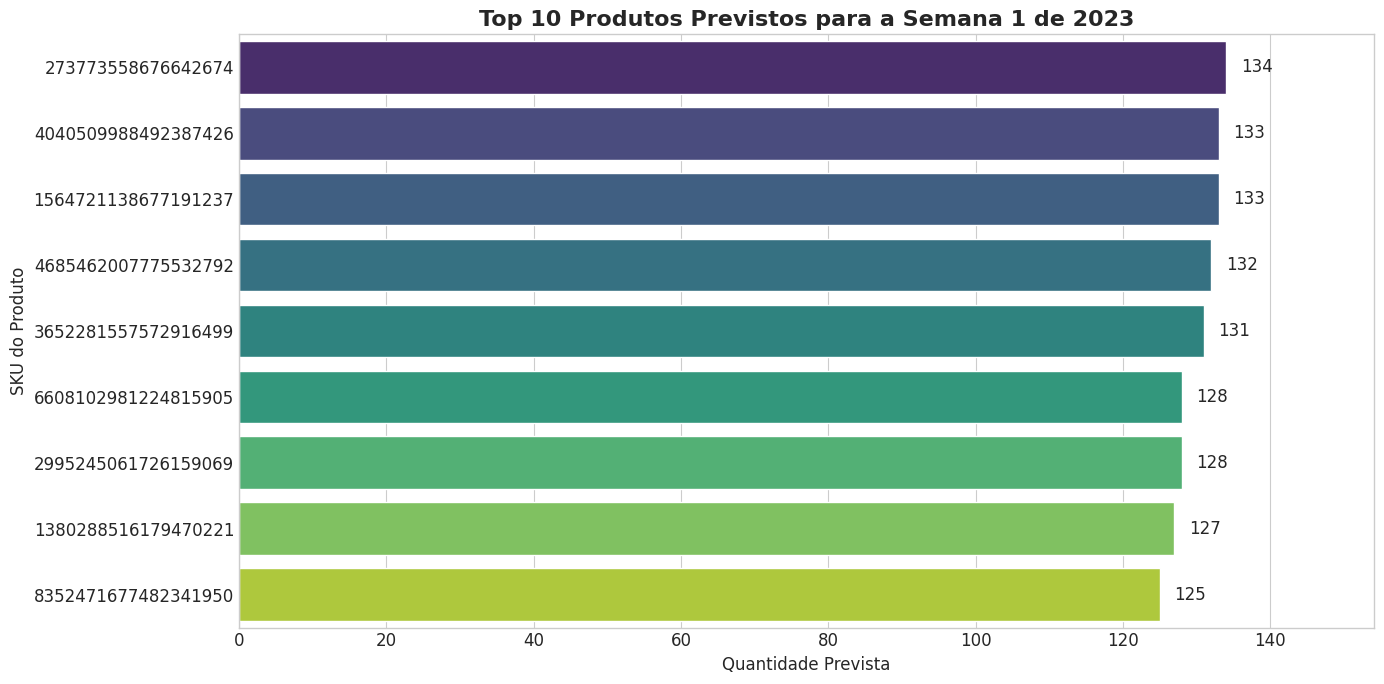

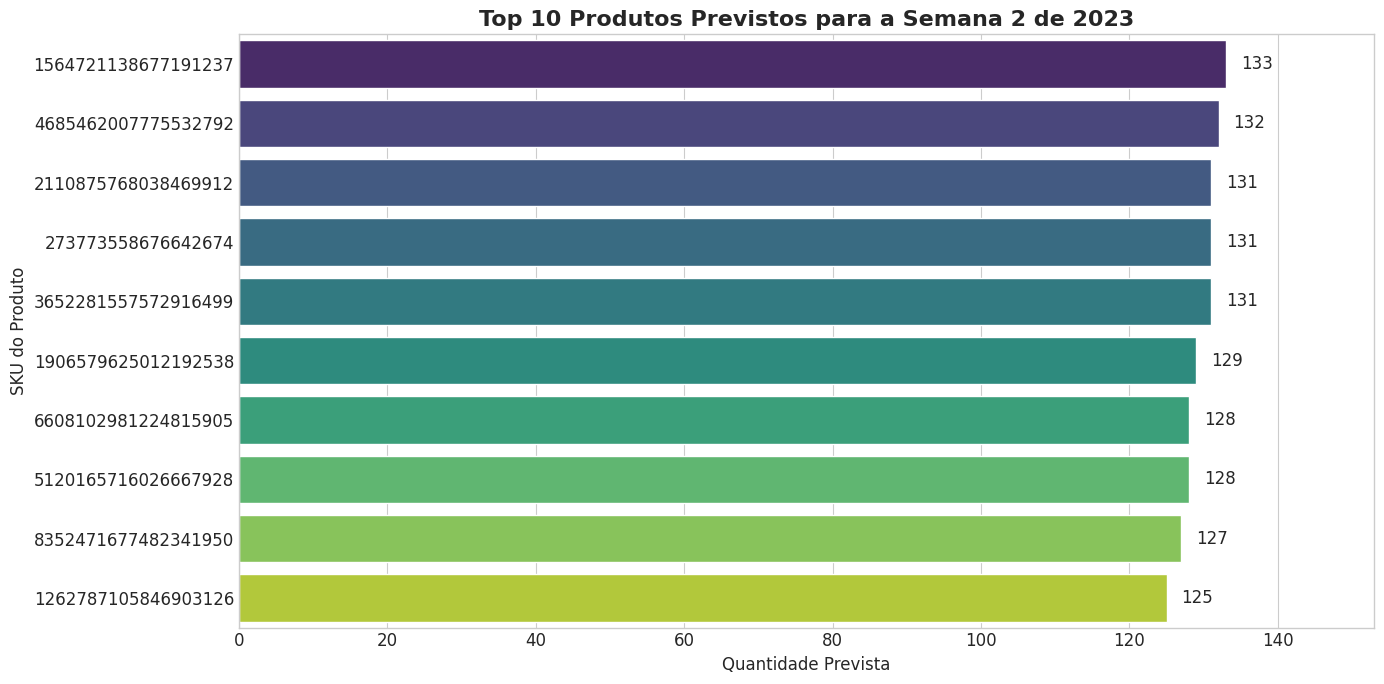

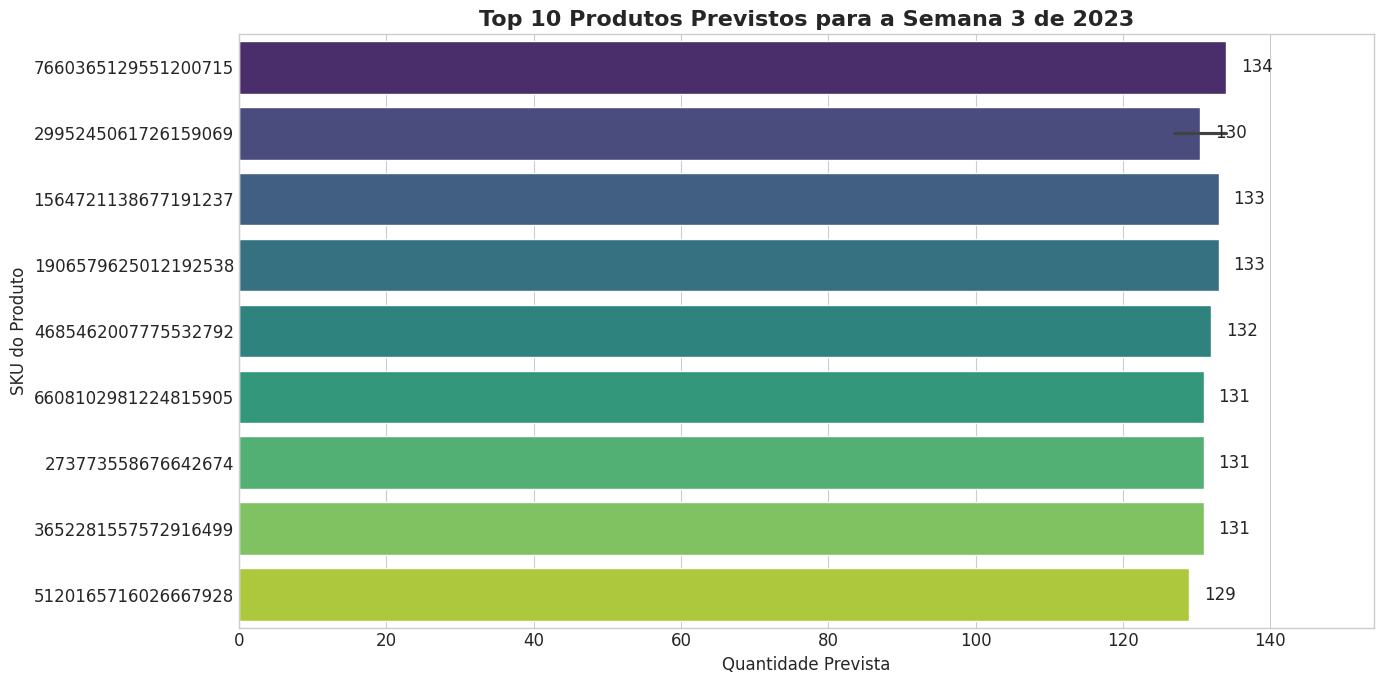

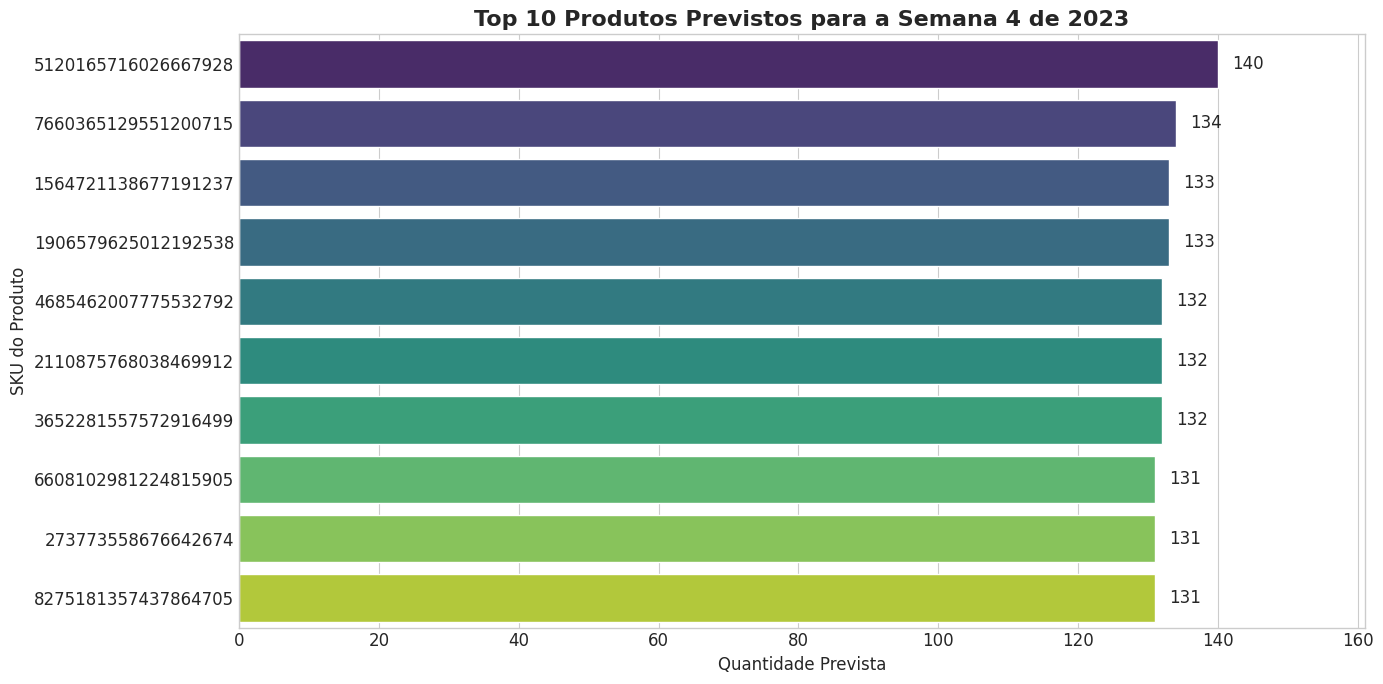

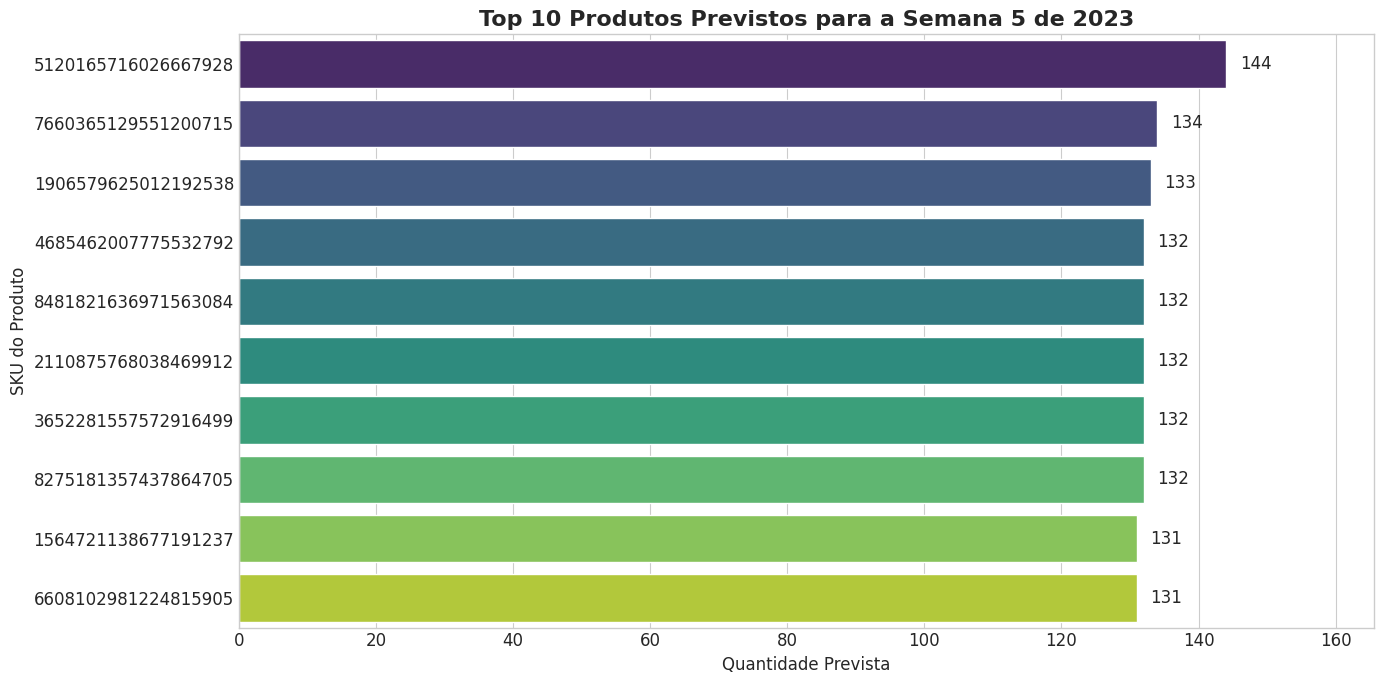

In [ ]:
# TOP 10 PRODUTOS POR SEMANA

# Pega a lista de semanas únicas para as quais temos previsão
semanas_previstas = sorted(df_forecast['semana'].unique())

for semana in semanas_previstas:
    # Filtra os dados para a semana atual e pega os 30 primeiros
    df_semana = df_forecast[df_forecast['semana'] == semana].head(10)

    # gráfico
    plt.figure(figsize=(14, 7))
    ax = sns.barplot(
        data=df_semana,
        x='quantidade_prevista',
        y='sku',
        palette='viridis'
    )

    # Adiciona os valores no final das barras
    for patch in ax.patches:
        width = patch.get_width()

        y = patch.get_y() + patch.get_height() / 2

        ax.text(x=width + 2,
                y=y,
                s=f'{int(width)}',
                ha='left',
                va='center')

    # Títulos e rótulos
    plt.title(f'Top 10 Produtos Previstos para a Semana {semana} de 2023', fontsize=16, weight='bold')
    plt.xlabel('Quantidade Prevista', fontsize=12)
    plt.ylabel('SKU do Produto', fontsize=12)
    plt.xlim(right=df_semana['quantidade_prevista'].max() * 1.15)
    plt.tight_layout()


    plt.show()